In [1]:
# --- imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.cm as cm

from helpers import load_fixeddepth_summary, collect_summaries, make_key


OUT_DIR = "../paper_figures/"
os.makedirs(OUT_DIR, exist_ok=True)
# dataset-specific beta/gamma
BG = {
    "DTU":       {"beta": [0.04],  "gamma": [0.005]},
    "abm":       {"beta": [0.01],  "gamma": [0.005]},
    "workplace": {"beta": [0.30],  "gamma": [0.005]},
    "abm30":     {"beta": [0.005], "gamma": [0.002]},
    "abm60":     {"beta": [0.002], "gamma": [0.001]},
}


# build the exact filter dict you gave (but with ibl=True to get the dashed baseline)
def make_filters(network_name):
    return dict(
        variants        = ["without", "dynThresh_FRem"],
        ds              = [0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 2],
        fixed_frac      = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.0, None],
        top_node_frac   = [1.0, None],
        max_rf          = [1.0, None],
        ii              = [24],
        fixed_threshold = [True, False],
        nprv            = [1],
        risk_model      = ["degree"],
        window          = [24],
        accel_weight    = [1.0],
        pt_weight       = [1.0],
        rise_smoothing  = [1],
        drop_smoothing  = [1],
        beta            = BG[network_name]["beta"],
        gamma           = BG[network_name]["gamma"],
        ibl             = [False],   # ← include intervention-baseline for dashed grey
        compliance      = [1.0],
    )

# --- load datasets ------------------------------------------------------------
def load_dataset(network_name):
    RESULTS_DIR = f"../results_{network_name}"
    CACHE_DIR   = f"../cache_{network_name}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    filters = make_filters(network_name)
    print(f"Loading {network_name} …")
    df, cache = load_fixeddepth_summary(RESULTS_DIR, CACHE_DIR, filters)
    return df, cache


df_abm,   cache_abm   = load_dataset("abm")
df_dtu,   cache_dtu   = load_dataset("DTU")
df_office,cache_office= load_dataset("workplace")

summ_abm = collect_summaries(df_abm,   cache_abm)
summ_dtu = collect_summaries(df_dtu,   cache_dtu)
summ_office = collect_summaries(df_office,cache_office)

Loading abm …
Loading 8 baseline + 0 risk-depth + 64 fixed-depth files
✓ results_without_ii24_ds100_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (1/72)
✓ results_without_ii24_ds110_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (2/72)
✓ results_without_ii24_ds200_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (3/72)
✓ results_without_ii24_ds50_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (4/72)
✓ results_without_ii24_ds150_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (from cache)   (5/72)
✓ results_without_ii24_ds130_mrfNA_fremNA_tnfNA_ibl0_c100_ftFalse_nprv1_rmdegree_w24_aw1p0_pt1p0_rs1p0_dsp1p0_b0p01_g0p005_BASELINE.zip (fro

In [2]:


# ---------- helpers ----------
def _build_ds_norm_across(dfs, cmap_name="plasma"):
    """Global λ (drop_strength) norm/cmap across multiple dataframes."""
    all_ds = []
    for df in dfs:
        ds = df[df.variant != "without"]["drop_strength"].dropna().values
        if ds.size:
            all_ds.append(ds)
    if not all_ds:
        raise ValueError("No drop_strength values found.")
    all_ds = np.concatenate(all_ds)
    vmin, vmax = float(np.nanmin(all_ds)), float(np.nanmax(all_ds))
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    return norm, cmap

def _phi_size_fn(max_area=300.0):
    """Bubble area as a function of φ."""
    return lambda phi: max_area * float(phi)

def _make_phi_size_legend(handles_phi, size_fn, tick_fs):
    """Build size legend handles for chosen φ values (if present)."""
    return [
        Line2D([], [], marker="o", ls="",
               markerfacecolor="grey", markeredgecolor="k",
               markersize=np.sqrt(size_fn(phi)), alpha=0.6,
               label=fr"$\phi={phi:.2f}$")
        for phi in handles_phi
    ]

# ---------- row-1 panel: peak reduction vs edges removed ----------
def plot_efficiency_bubble_panel_R1(
    ax, df, *, norm, cmap,
    axis_fs=12, tick_fs=10,
    add_size_legend=False,
    legend_phis=(0.10, 0.50, 1.00),
    max_area=300.0,
    alpha_points=0.5,
):
    inter = df[df.variant != "without"].dropna(
        subset=["edges_removed_pct", "peak_reduced_pct", "fixed_frac", "drop_strength"]
    )
    if inter.empty:
        return

    size_fn = _phi_size_fn(max_area=max_area)

    sc = ax.scatter(
        inter["edges_removed_pct"].astype(float),
        inter["peak_reduced_pct"].astype(float),
        s=inter["fixed_frac"].astype(float).map(size_fn),
        c=inter["drop_strength"].astype(float),
        cmap=cmap, norm=norm,
        alpha=alpha_points, edgecolors="k", linewidths=0.4
    )

    ax.set_xlabel("Edges removed [%]", fontsize=axis_fs)
    ax.set_ylabel("Peak infection\nreduction [%]", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.5)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if add_size_legend:
        # only include φ values that actually exist in the data
        present = set(np.round(inter["fixed_frac"].astype(float), 2))
        chosen  = [p for p in legend_phis if p in present]
        if chosen:
            handles = _make_phi_size_legend(chosen, size_fn, tick_fs)
            ax.legend(handles=handles, frameon=False, fontsize=tick_fs, loc="lower right")

# ---------- row-2 panel: peak reduction vs Σ high-risk selections ----------
def plot_peak_exposure_bubble_panel_R2(
    ax, df, summaries, *, norm, cmap,
    network_name,
    axis_fs=12, tick_fs=10,
    add_size_legend=False,
    legend_phis=(0.10, 0.50, 1.00),
    max_area=300.0,
    alpha_points=0.6,
):
    """
    Σ high-risk selections on x, ΔPeak [%] on y. Color=λ, Area=φ.
    Requires 'summaries' dict keyed like your previous code (contains avg_high_risk_node_counts).
    """
    import re
    rows = []
    for label, summ in summaries.items():
        if label.startswith("without_"):
            continue
        ds_m = re.search(r"_ds([0-9.]+)", label)
        cap_m = re.search(r"_cap([0-9.]+)", label)
        if not (ds_m and cap_m):
            continue
        lam = float(ds_m.group(1))
        phi = float(cap_m.group(1))
        exposures = float(np.sum(summ["avg_high_risk_node_counts"]))

        variant = label.split("_cap")[0] if "_cap" in label else label.split("_ds")[0]
        sel = (
            (df.variant == variant) &
            (df.drop_strength == lam) &
            (df.fixed_frac == phi)
        )
        if not sel.any():  # skip pairs not present in df
            continue
        dpeak = float(df.loc[sel, "peak_reduced_pct"].iat[0])
        rows.append((exposures, dpeak, phi, lam))

    if not rows:
        return

    size_fn = _phi_size_fn(max_area=max_area)
    for exposures, dpeak, phi, lam in rows:
        ax.scatter(
            exposures, dpeak,
            s=size_fn(phi),
            c=[cmap(norm(lam))],
            edgecolor="k", linewidth=0.5, alpha=alpha_points
        )

    ax.set_xlabel(r"$\Sigma$ high-risk selections", fontsize=axis_fs)
    ax.set_ylabel("Peak infection\nreduction [%]", fontsize=axis_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(linestyle=":", alpha=0.5)
    ax.set_ylim(bottom=0)

    # if add_size_legend:
    #     present = set(np.round([r[2] for r in rows], 2))
    #     chosen  = [p for p in legend_phis if p in present]
    #     if chosen:
    #         handles = _make_phi_size_legend(chosen, size_fn, tick_fs)
    #         ax.legend(handles=handles, frameon=False, fontsize=tick_fs, loc="lower right")

# ---------- full 2×3 figure ----------
def fig_bubbles_2x3(
    *,
    dfs,            # list/tuple of 3 dfs: [df_abm, df_dtu, df_workplace] (order = columns A/B/C, D/E/F)
    summaries,      # list/tuple of 3 summary dicts aligned with dfs
    names,          # list/tuple of 3 dataset names (e.g. ["abm","DTU","workplace"])
    out_path="Fig_bubbles_2x3.tif",
    cmap_name="plasma",
    figsize=(10.5, 5.2),
    axis_fs=12,
    tick_fs=10
):
    """
    Row 1: ΔPeak vs Edges removed (A,B,C)
    Row 2: ΔPeak vs Σ high-risk selections (D,E,F)
    Legend for φ only on panel A (0.10, 0.50, 1.00). 
    Shared λ colorbar at the right of each row.
    """
    assert len(dfs) == len(summaries) == len(names) == 3, "Need exactly 3 datasets."

    # global λ mapping
    norm, cmap = _build_ds_norm_across(dfs, cmap_name=cmap_name)

    fig, axes = plt.subplots(2, 3, figsize=figsize, dpi=150, constrained_layout=True)

    # Row 1
    for j in range(3):
        ax = axes[0, j]
        plot_efficiency_bubble_panel_R1(
            ax, dfs[j], norm=norm, cmap=cmap,
            axis_fs=axis_fs, tick_fs=tick_fs,
            add_size_legend=(j == 0),
            legend_phis=(0.10, 0.50, 1.00),
            max_area=300.0, alpha_points=0.5
        )
        if j > 0:
            ax.set_ylabel("")  # remove duplicate y-labels

    # Row 2
    for j in range(3):
        ax = axes[1, j]
        plot_peak_exposure_bubble_panel_R2(
            ax, dfs[j], summaries[j], norm=norm, cmap=cmap,
            network_name=names[j],
            axis_fs=axis_fs, tick_fs=tick_fs,
            add_size_legend=False,
            legend_phis=(0.10, 0.50, 1.00),
            max_area=300.0, alpha_points=0.6
        )
        if j > 0:
            ax.set_ylabel("")  # only keep y-label on col 1

    # panel letters
    letters = "ABCDEF"
    for i in range(2):
        for j in range(3):
            axes[i, j].text(-0.00, 1.03, letters[i*3+j],
                            transform=axes[i, j].transAxes,
                            fontsize=12, fontweight="bold", ha="left", va="bottom")

    # one λ colorbar per row
    for i in range(2):
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = fig.colorbar(
            sm, ax=axes[i, :].ravel().tolist(),
            location="right", fraction=0.035, pad=0.02, aspect=25
        )
        cbar.set_label(r"Sensitivity $\lambda$", fontsize=axis_fs)
        cbar.ax.tick_params(labelsize=tick_fs)

    # save @600 dpi, TIFF LZW (PLOS-friendly)
    fig.savefig(
        out_path, dpi=600, format="tiff",
        pil_kwargs={"compression": "tiff_lzw"},
        bbox_inches="tight"
    )
    print(f"✓ saved {out_path}")
    plt.show()


✓ saved ../paper_figures/Fig3.tif


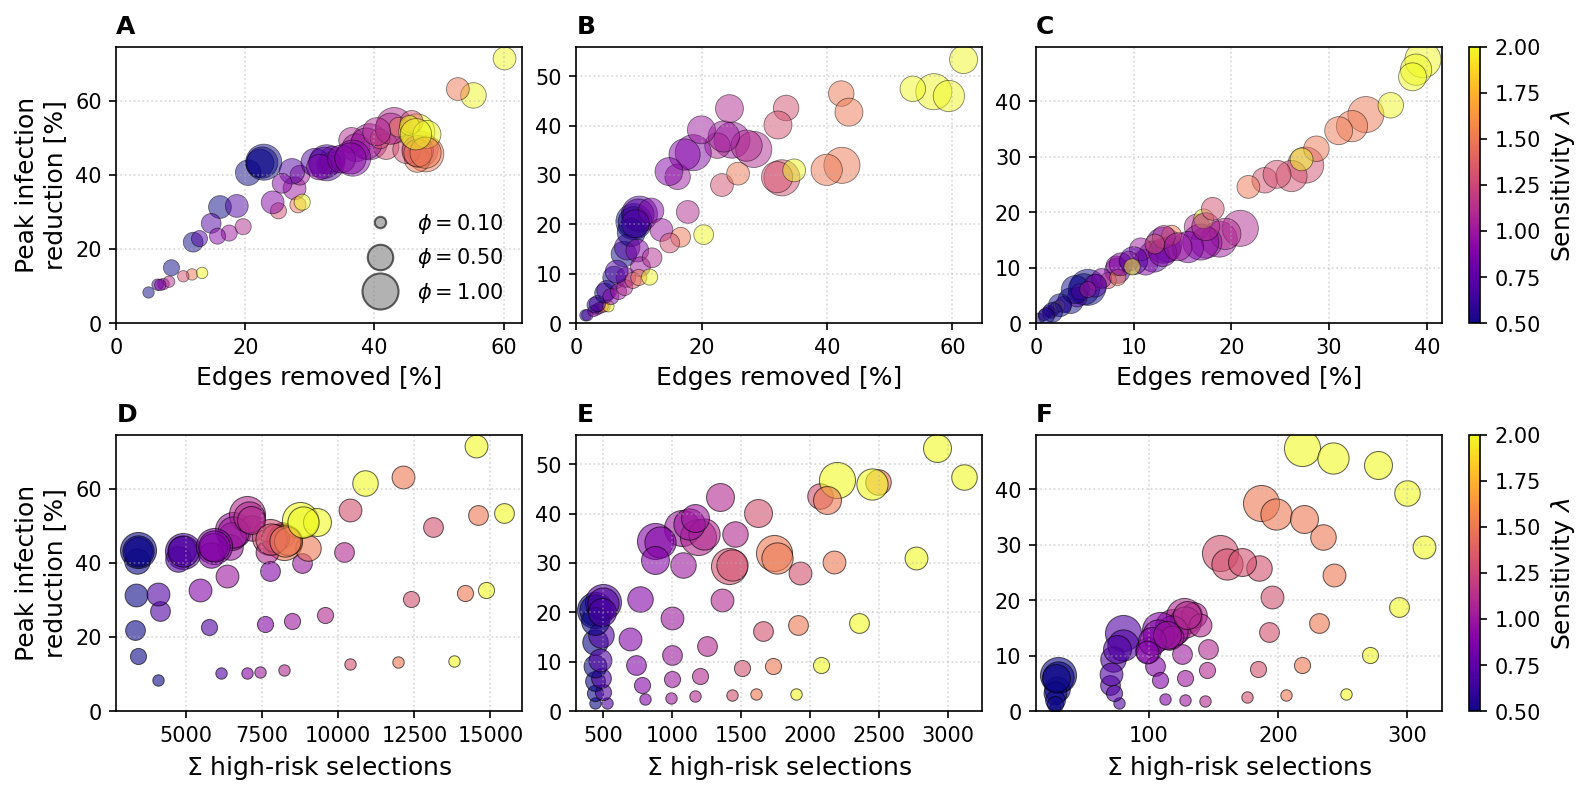

In [3]:
# example inputs (align columns with your preferred order)
dfs        = [df_abm, df_dtu, df_office]           # row 1 + row 2 use same order
summaries  = [summ_abm, summ_dtu, summ_office]
names      = ["abm", "DTU", "workplace"]

fig_bubbles_2x3(
    dfs=dfs,
    summaries=summaries,
    names=names,
    out_path=OUT_DIR + "Fig3.tif",
    cmap_name="plasma",
    figsize=(10.5, 5.2),  # tweak if you want larger bubbles
    axis_fs=12,
    tick_fs=10
)
